 # Hydrogeological EDA – Aquifer Water Level Analysis



 This notebook performs a complete exploratory data analysis (EDA) for:



 - Groundwater level (piezometric level)

 - Rainfall

 - Atmospheric pressure

 - Pumping well operational status

 - Earth tide (solid Earth tide components)



 Objectives:



 1. Assess data quality and consistency

 2. Understand statistical properties and distributions

 3. Explore temporal patterns (trend, seasonality, autocorrelation)

 4. Investigate hydrogeological relationships among variables

 5. Support the development of robust forecasting models (ML / DL)

 ## 0. Imports and Initial Configuration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Time series tools
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)



 ## 1. Load and Integrate Data



 Expected files (under `BASE_PATH`):



 - `nivel-pocos_chuva_pressao_tratados.csv`

 - `funcionamento_pocos_30min.csv`

 - `earth_tide.csv`

In [10]:
BASE_PATH = "."

path_level_rain_pressure = os.path.join(BASE_PATH, "data/nivel-pocos_chuva_pressao_tratados.csv")
path_wells_func = os.path.join(BASE_PATH, "data/funcionamento_pocos_30min.csv")
path_earth_tide = os.path.join(BASE_PATH, "data/earth_tide.csv")

# Load datasets
level_rain_pressure = pd.read_csv(path_level_rain_pressure)
wells_func = pd.read_csv(path_wells_func, sep=",")
earth_tide = pd.read_csv(path_earth_tide)

# Standardize time column
if "datetime" in earth_tide.columns:
    earth_tide = earth_tide.rename(columns={"datetime": "date_time"})

# Validate time column existence
for df in [level_rain_pressure, wells_func, earth_tide]:
    if "date_time" not in df.columns:
        raise ValueError("Dataset missing 'date_time' column.")

# Convert pumping well status columns to integers
wells_func = wells_func.dropna()
cols_func = wells_func.columns.difference(["date_time"])
wells_func[cols_func] = wells_func[cols_func].astype(int)

# Merge all dataframes
data = (
    level_rain_pressure
    .merge(wells_func, on="date_time", how="outer")
    .merge(earth_tide, on="date_time", how="outer")
)

# Convert time and sort chronologically
data["date_time"] = pd.to_datetime(data["date_time"])
data = data.sort_values("date_time").reset_index(drop=True)

print("Final merged dataset shape:", data.shape)
data.head()



Final merged dataset shape: (70080, 10)


,date_time,pressao_mH2O_final,gmu_level_mH2O_compensado,grafica_level_mH2O_compensado,correios_level_mH2O_compensado,chuva_mm_30min,status_IMECC,status_FEF,status_ZOOLOGIA,earth_tide_nm/s2
0,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.263
1,2022-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-161.201
2,2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-279.700
3,2022-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-351.661
4,2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-371.415


 ## 1.1 Data Period Selection



 Define the time window to be used for the entire notebook.

 All subsequent analyses will be performed only on this filtered date range.

In [15]:
# ---------------------------------------
# 1.1 Select Data Period
# ---------------------------------------

# Define start and end date here
# Example:
# start_date = "2021-01-01"
# end_date   = "2022-01-01"

start_date = "2022-05-11 00:00:00"   # or None / "YYYY-MM-DD"
end_date = "2022-07-11 11:00:00"     # or None / "YYYY-MM-DD"

# Ensure datetime format
data["date_time"] = pd.to_datetime(data["date_time"])

# Apply filtering only if values are provided
filtered_data = data.copy()

if start_date is not None:
    filtered_data = filtered_data[filtered_data["date_time"] >= pd.to_datetime(start_date)]

if end_date is not None:
    filtered_data = filtered_data[filtered_data["date_time"] <= pd.to_datetime(end_date)]

# Create the time-indexed version, filtered
data_ts = filtered_data.set_index("date_time").sort_index()

print("Selected date range:")
print(f"  Start: {data_ts.index.min()}")
print(f"  End:   {data_ts.index.max()}")
print(f"Filtered dataset shape: {filtered_data.shape}")

data_ts.head()



Selected date range:
  Start: 2022-05-11 00:00:00
  End:   2022-07-11 11:00:00
Filtered dataset shape: (2951, 10)


,pressao_mH2O_final,gmu_level_mH2O_compensado,grafica_level_mH2O_compensado,correios_level_mH2O_compensado,chuva_mm_30min,status_IMECC,status_FEF,status_ZOOLOGIA,earth_tide_nm/s2
date_time,,,,,,,,,
2022-05-11 00:00:00,9.647714,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-707.861
2022-05-11 00:30:00,9.647893,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-701.156
2022-05-11 01:00:00,9.648072,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-655.089
2022-05-11 01:30:00,9.648367,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-573.884
2022-05-11 02:00:00,9.648663,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-464.133


 ## 2. Data Quality Assessment



 Includes:



 - Missing values

 - Duplicates

 - Value ranges (sanity checks)

 - Time gaps and frequency irregularities

 ### 2.1 General overview and data types

In [16]:
print("\nGeneral info (filtered period):")
data_ts.info()

print("\nDescriptive statistics (numeric variables) – filtered period:")
display(data_ts.describe().T)




General info (filtered period):
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2951 entries, 2022-05-11 00:00:00 to 2022-07-11 11:00:00
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pressao_mH2O_final              2951 non-null   float64
 1   gmu_level_mH2O_compensado       2920 non-null   float64
 2   grafica_level_mH2O_compensado   0 non-null      float64
 3   correios_level_mH2O_compensado  0 non-null      float64
 4   chuva_mm_30min                  2951 non-null   float64
 5   status_IMECC                    2951 non-null   float64
 6   status_FEF                      2951 non-null   float64
 7   status_ZOOLOGIA                 2951 non-null   float64
 8   earth_tide_nm/s2                2951 non-null   float64
dtypes: float64(9)
memory usage: 230.5 KB

Descriptive statistics (numeric variables) – filtered period:


,count,mean,std,min,25%,50%,75%,max
pressao_mH2O_final,2951.0,9.661023,0.027353,9.583489,9.640471,9.663697,9.681862,9.724483
gmu_level_mH2O_compensado,2920.0,21.597772,0.281068,20.714187,21.420863,21.604792,21.815748,22.186641
grafica_level_mH2O_compensado,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
correios_level_mH2O_compensado,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chuva_mm_30min,2951.0,0.051215,0.616686,0.000000,0.000000,0.000000,0.000000,23.370000
status_IMECC,2951.0,0.315825,0.464922,0.000000,0.000000,0.000000,1.000000,1.000000
status_FEF,2951.0,0.169434,0.375198,0.000000,0.000000,0.000000,0.000000,1.000000
status_ZOOLOGIA,2951.0,0.328363,0.469697,0.000000,0.000000,0.000000,1.000000,1.000000
earth_tide_nm/s2,2951.0,-144.909744,683.934895,-2127.379000,-590.496000,-58.388000,401.316500,1092.649000


 ### 2.2 Missing values

Missing values per column (filtered period):


,missing_count,missing_percent
grafica_level_mH2O_compensado,2951,100.000000
correios_level_mH2O_compensado,2951,100.000000
gmu_level_mH2O_compensado,31,1.050491
pressao_mH2O_final,0,0.000000
chuva_mm_30min,0,0.000000
status_IMECC,0,0.000000
status_FEF,0,0.000000
status_ZOOLOGIA,0,0.000000
earth_tide_nm/s2,0,0.000000


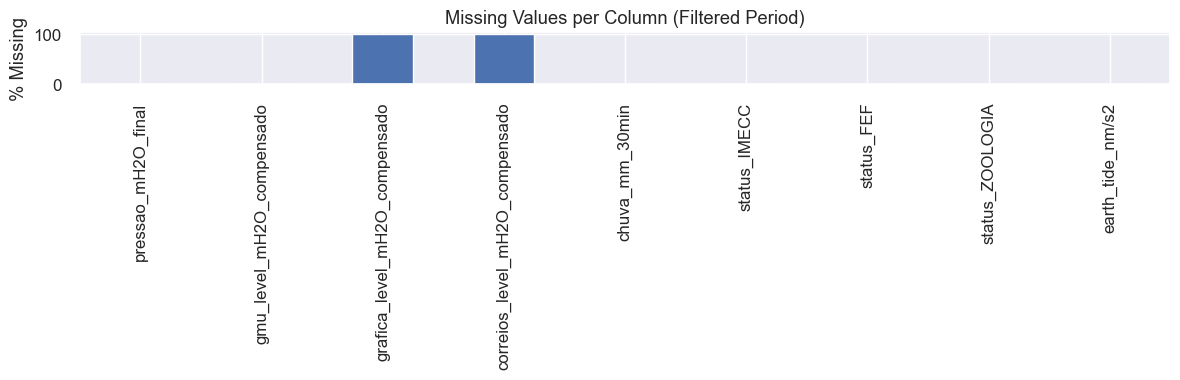

In [17]:
missing_counts = data_ts.isna().sum()
missing_percent = (missing_counts / len(data_ts)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
}).sort_values("missing_percent", ascending=False)

print("Missing values per column (filtered period):")
display(missing_df.head(30))

plt.figure(figsize=(12, 4))
missing_percent.plot(kind="bar")
plt.ylabel("% Missing")
plt.title("Missing Values per Column (Filtered Period)")
plt.tight_layout()
plt.show()



 ### 2.3 Duplicate timestamps

In [18]:
duplicates = filtered_data["date_time"].duplicated().sum()
print("Number of duplicated timestamps in filtered period:", duplicates)

if duplicates > 0:
    display(filtered_data[filtered_data["date_time"].duplicated(keep=False)].head())



Number of duplicated timestamps in filtered period: 0


 ### 2.4 Time-series frequency and gaps (Filtered Period Only)

In [19]:
# Use ONLY the filtered and time-indexed series

freq_guess = pd.infer_freq(data_ts.index)
print("Inferred sampling frequency (filtered period):", freq_guess)

# Check for missing timestamps assuming 30-minute interval
expected_freq = "30T"
full_range = pd.date_range(start=data_ts.index.min(), end=data_ts.index.max(), freq=expected_freq)
missing_timestamps = full_range.difference(data_ts.index)

print("Expected timestamps within selected range:", len(full_range))
print("Present timestamps:", len(data_ts))
print("Missing timestamps:", len(missing_timestamps))

if len(missing_timestamps) > 0:
    print("\nExamples of missing timestamps:")
    print(list(missing_timestamps[:20]))



Inferred sampling frequency (filtered period): 30T
Expected timestamps within selected range: 2951
Present timestamps: 2951
Missing timestamps: 0


 ### 2.5 Outlier detection (z-score method)



 Gaps are preserved in the plots (NaNs are kept in the full series so missing periods appear as breaks).

gmu_level_mH2O_compensado: 9 potential outliers (|z| > 3)


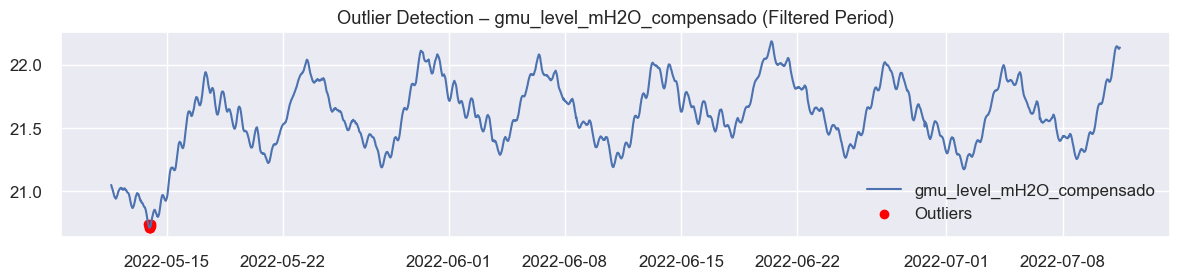

chuva_mm_30min: 22 potential outliers (|z| > 3)


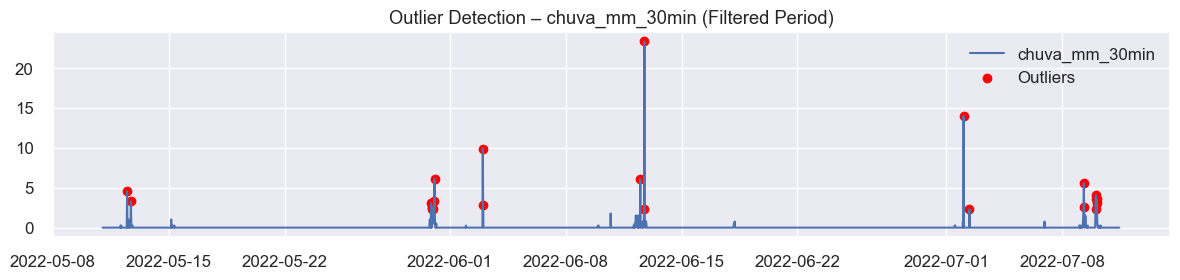

pressao_mH2O_final: 0 potential outliers (|z| > 3)


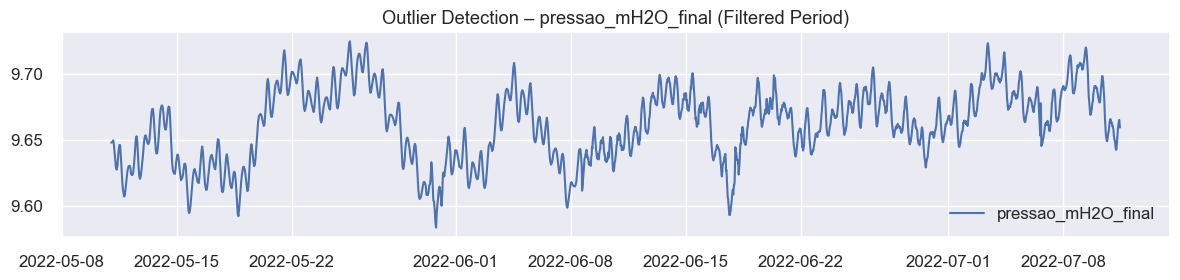

In [20]:
key_cols = [
    col for col in [
        "gmu_level_mH2O_compensado",
        "chuva_mm_30min",
        "pressao_mH2O_final"
    ] if col in data_ts.columns
]

for col in key_cols:
    full_series = data_ts[col]          # keeps NaNs → gaps visible in plot
    series_no_na = full_series.dropna() # used only for z-score

    if series_no_na.empty:
        print(f"{col}: no data available in selected period.")
        continue

    zscores = np.abs(stats.zscore(series_no_na))
    outliers = series_no_na[zscores > 3]

    print(f"{col}: {len(outliers)} potential outliers (|z| > 3)")

    plt.figure(figsize=(12, 3))
    plt.plot(full_series.index, full_series.values, label=col)
    if not outliers.empty:
        plt.scatter(outliers.index, outliers.values, color="red", label="Outliers")
    plt.title(f"Outlier Detection – {col} (Filtered Period)")
    plt.legend()
    plt.tight_layout()
    plt.show()



 ## 3. Basic Statistical Analysis & Distribution Exploration



 - Distribution shapes

 - Skewness, kurtosis

 - Histograms and KDE plots

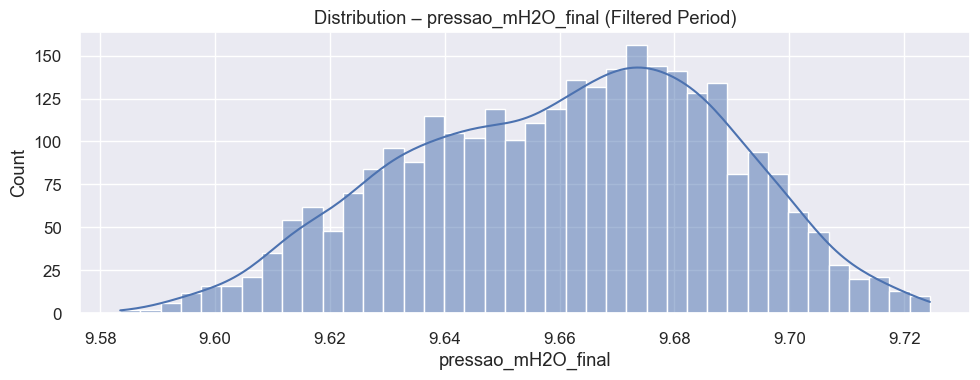

pressao_mH2O_final – Skewness: -0.199, Kurtosis: -0.621
--------------------------------------------------


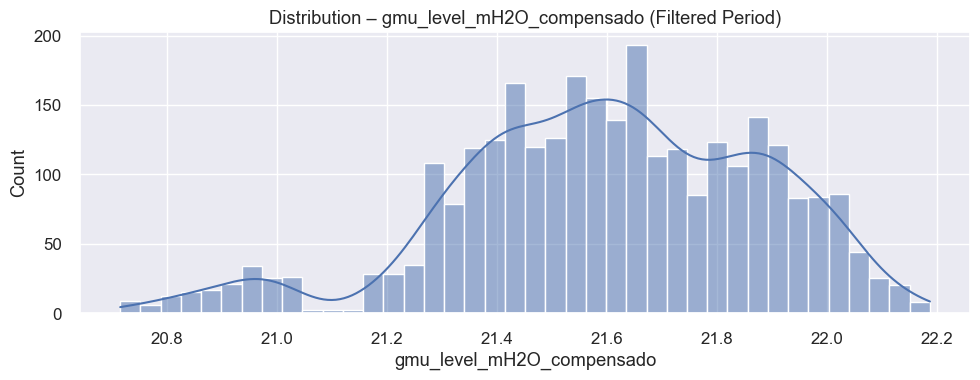

gmu_level_mH2O_compensado – Skewness: -0.495, Kurtosis: 0.177
--------------------------------------------------


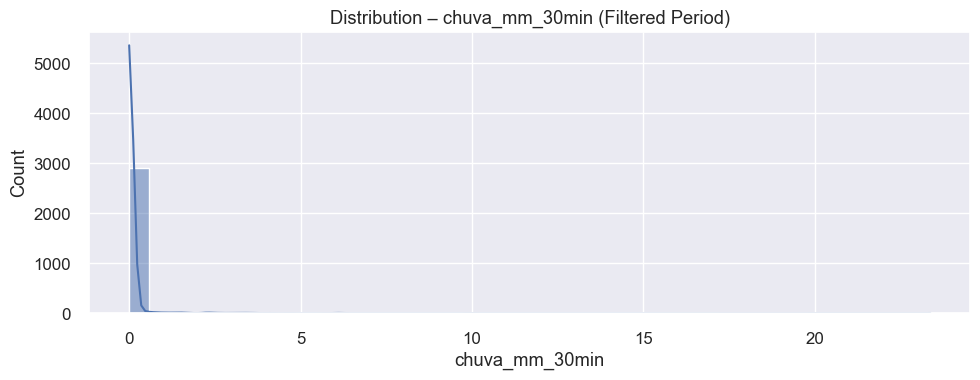

chuva_mm_30min – Skewness: 25.246, Kurtosis: 814.172
--------------------------------------------------


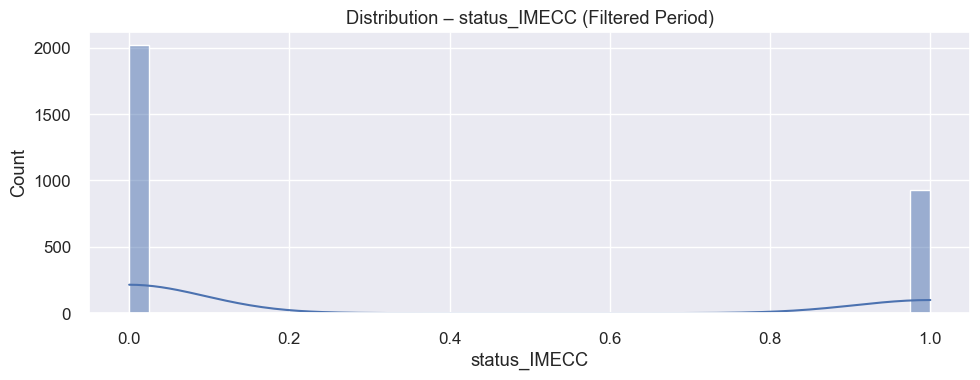

status_IMECC – Skewness: 0.793, Kurtosis: -1.372
--------------------------------------------------


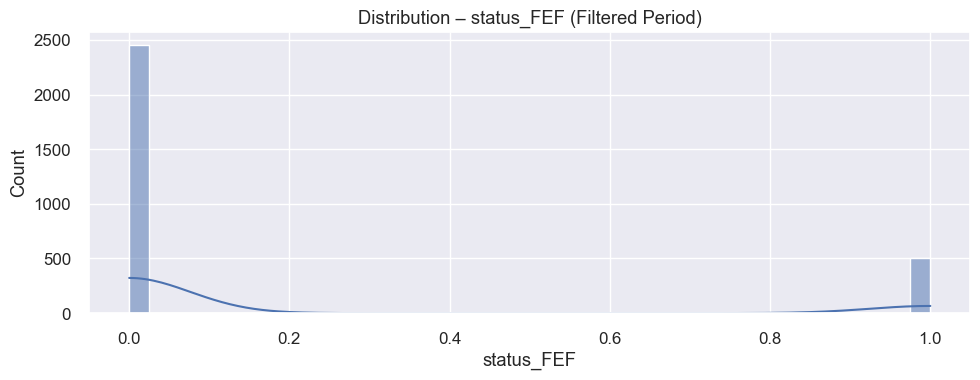

status_FEF – Skewness: 1.763, Kurtosis: 1.110
--------------------------------------------------


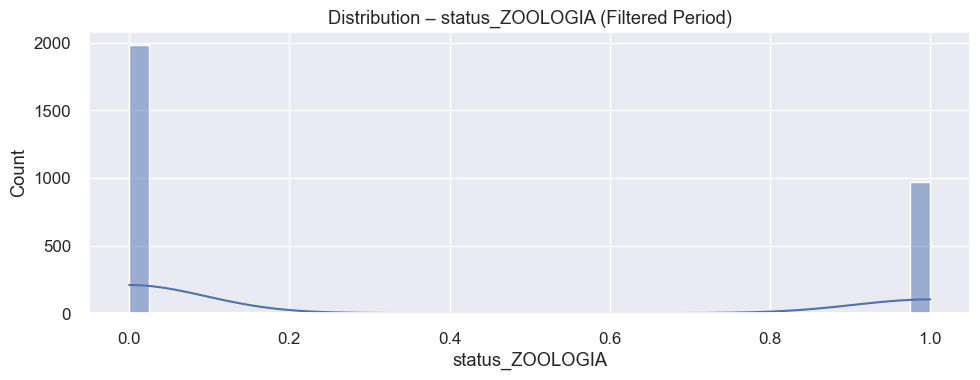

status_ZOOLOGIA – Skewness: 0.731, Kurtosis: -1.466
--------------------------------------------------


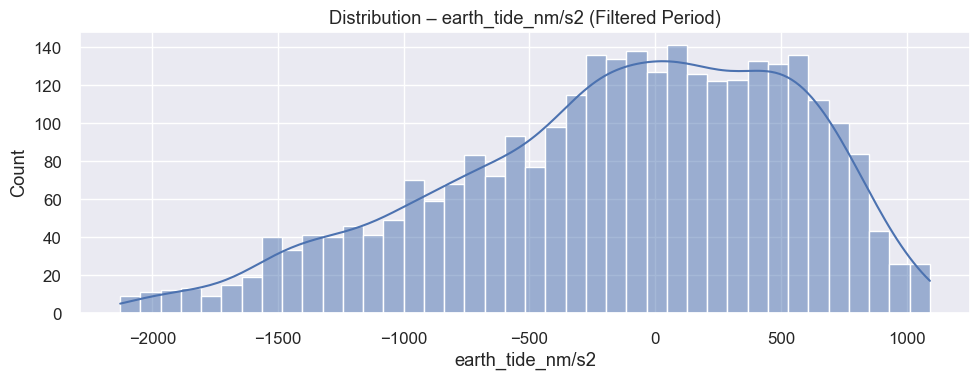

earth_tide_nm/s2 – Skewness: -0.545, Kurtosis: -0.343
--------------------------------------------------


In [21]:
num_cols = data_ts.select_dtypes(include=[np.number]).columns

for col in num_cols:
    series = data_ts[col].dropna()
    if series.empty:
        continue

    plt.figure(figsize=(10, 4))
    sns.histplot(series, kde=True, bins=40)
    plt.title(f"Distribution – {col} (Filtered Period)")
    plt.tight_layout()
    plt.show()

    print(f"{col} – Skewness: {series.skew():.3f}, Kurtosis: {series.kurt():.3f}")
    print("-" * 50)



 ## 4. Time-Series Exploration



 Includes:



 - Trend and seasonal decomposition (STL)

 - Autocorrelation (ACF) and partial autocorrelation (PACF)

 - Temporal plots

 ### 4.1 Time-series plots

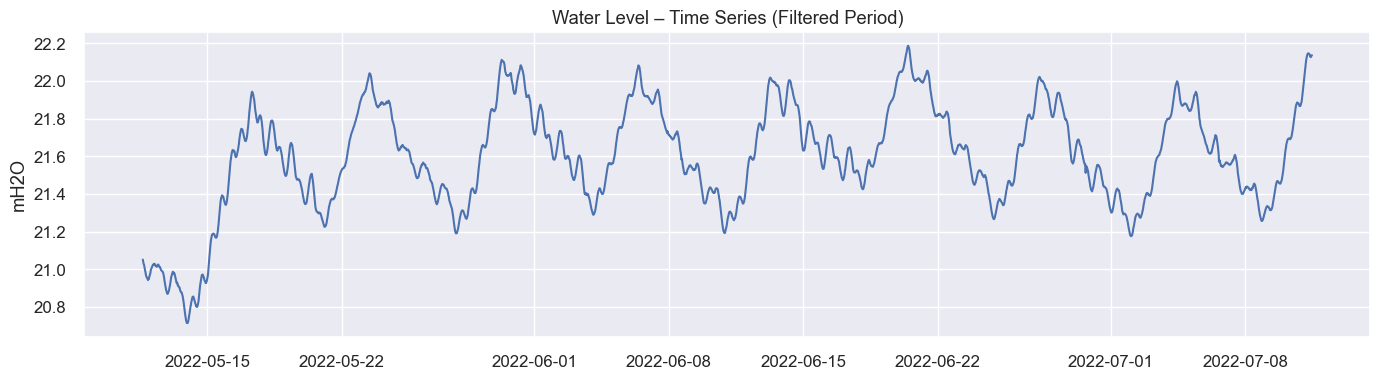

In [22]:
plt.figure(figsize=(14, 4))
plt.plot(data_ts.index, data_ts["gmu_level_mH2O_compensado"], label="Water Level")
plt.title("Water Level – Time Series (Filtered Period)")
plt.ylabel("mH2O")
plt.tight_layout()
plt.show()



 ### 4.2 STL decomposition



 Note: This uses the filtered period. For heavily gapped data, a block-wise STL decomposition may be preferable.

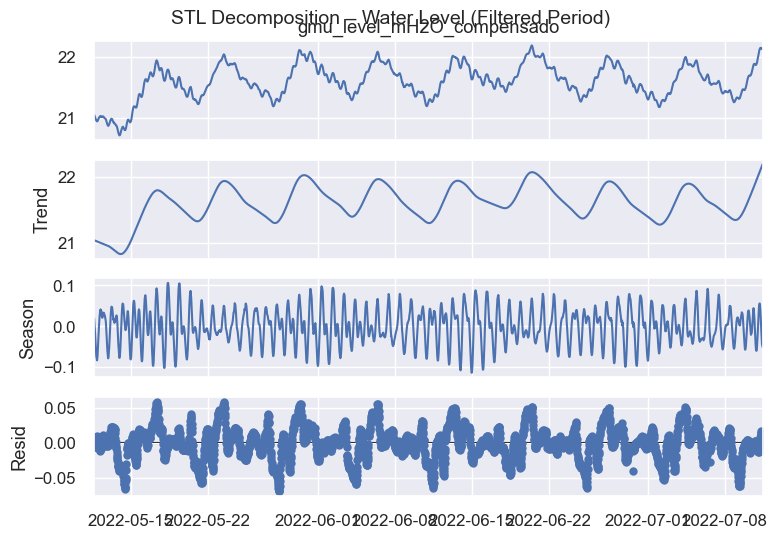

In [23]:
series = data_ts["gmu_level_mH2O_compensado"].dropna()

if series.empty:
    print("No data available for STL decomposition in the selected period.")
else:
    series = series.asfreq("30T")

    stl = STL(series, period=48)  # 48 half-hour steps ≈ 1 day
    result = stl.fit()
    result.plot()
    plt.suptitle("STL Decomposition – Water Level (Filtered Period)", fontsize=14)
    plt.show()



 ### 4.3 ACF & PACF

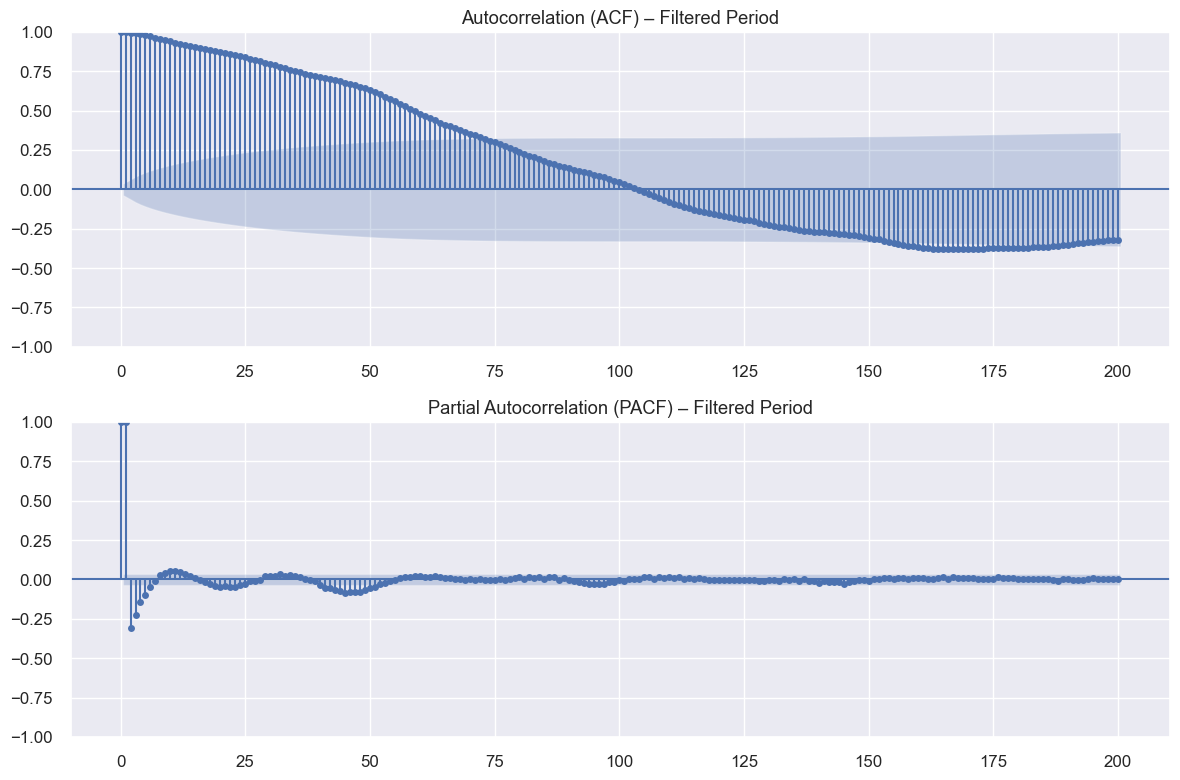

In [24]:
series_acf = data_ts["gmu_level_mH2O_compensado"].dropna()

if series_acf.empty:
    print("No data available for ACF/PACF in the selected period.")
else:
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(series_acf, ax=ax[0], lags=200)
    plot_pacf(series_acf, ax=ax[1], lags=200)

    ax[0].set_title("Autocorrelation (ACF) – Filtered Period")
    ax[1].set_title("Partial Autocorrelation (PACF) – Filtered Period")
    plt.tight_layout()
    plt.show()



 ## 5. Hydrogeological Variable Relationships



 Includes:



 - Correlation matrix

 - Pairwise plots

 - Cross-correlation (rain → water level, pressure → level, etc.)

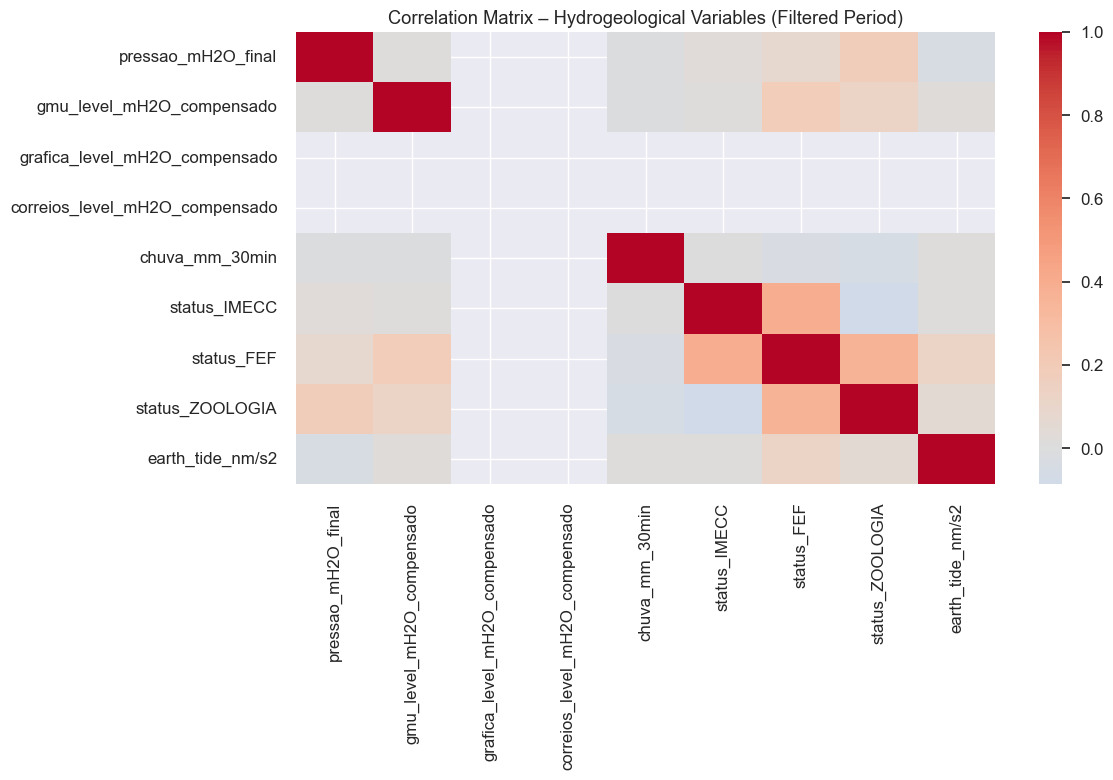

In [25]:
corr = data_ts.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix – Hydrogeological Variables (Filtered Period)")
plt.tight_layout()
plt.show()



 ## 6. Hydrogeological Event Analysis



 Examples:



 - Rainfall events and corresponding groundwater response

 - Recharge delay analysis

 - Pumping influence on water level

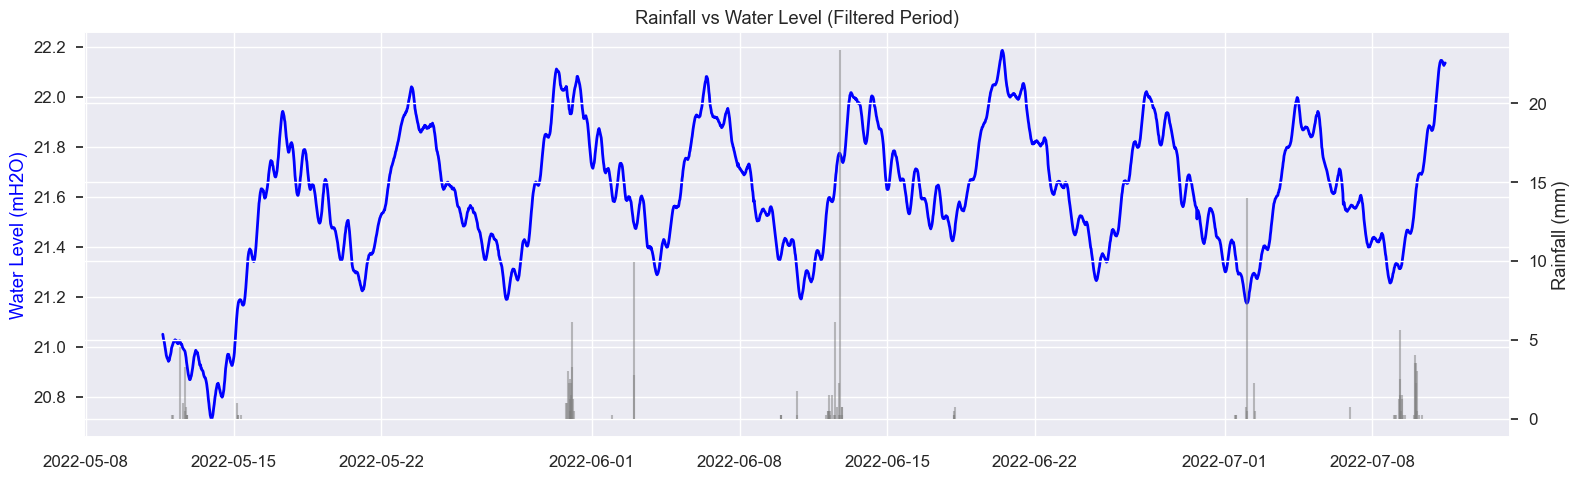

In [27]:
fig, ax1 = plt.subplots(figsize=(16, 5))

# Water level
ax1.plot(data_ts.index, data_ts["gmu_level_mH2O_compensado"], 
         color="blue", linewidth=2)
ax1.set_ylabel("Water Level (mH2O)", color="blue")

# Rainfall as vertical spikes
ax2 = ax1.twinx()
ax2.vlines(
    data_ts.index, 
    ymin=0, ymax=data_ts["chuva_mm_30min"],
    color="gray", alpha=0.5
)
ax2.set_ylabel("Rainfall (mm)")

plt.title("Rainfall vs Water Level (Filtered Period)")
plt.tight_layout()
plt.show()


 ## 7. Sensor Consistency Analysis



 - Water level vs atmospheric pressure

 - Water level vs Earth tide

 - Check sensor drift or offsets

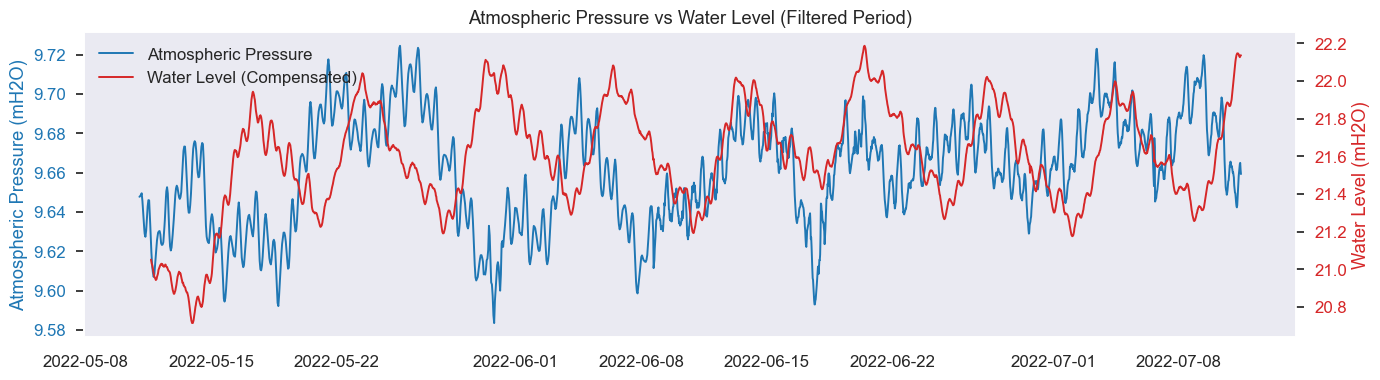

In [30]:
plt.figure(figsize=(14, 4))

ax1 = plt.gca()

# --- Eixo Y esquerdo (Pressão Barométrica) ---
ax1.plot(
    data_ts.index, 
    data_ts["pressao_mH2O_final"], 
    label="Atmospheric Pressure",
    linewidth=1.4,
    color="#1f77b4"
)
ax1.set_ylabel("Atmospheric Pressure (mH2O)", color="#1f77b4")
ax1.tick_params(axis='y', labelcolor="#1f77b4")

# Remover grid do eixo principal
ax1.grid(False)

# --- Eixo Y direito (Nível Compensado) ---
ax2 = ax1.twinx()
ax2.plot(
    data_ts.index, 
    data_ts["gmu_level_mH2O_compensado"], 
    label="Water Level (Compensated)",
    linewidth=1.4,
    color="#d62728"
)
ax2.set_ylabel("Water Level (mH2O)", color="#d62728")
ax2.tick_params(axis='y', labelcolor="#d62728")

# Garantir sem grid também no eixo secundário
ax2.grid(False)

# --- Título ---
plt.title("Atmospheric Pressure vs Water Level (Filtered Period)")

# --- Legendas combinadas ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()


 ## 8. Exploratory Feature Engineering



 - Lag features

 - Moving averages

 - Rainfall accumulations

 - Weekday/weekend flags

In [31]:
data_fe = data_ts.copy()

# Example feature set
if "gmu_level_mH2O_compensado" in data_fe.columns:
    data_fe["lag_1h"] = data_fe["gmu_level_mH2O_compensado"].shift(2)
    data_fe["lag_6h"] = data_fe["gmu_level_mH2O_compensado"].shift(12)

if "chuva_mm_30min" in data_fe.columns:
    data_fe["rain_6h"] = data_fe["chuva_mm_30min"].rolling(12).sum()

data_fe["is_weekday"] = (data_fe.index.weekday < 5).astype(int)

data_fe.head()



,pressao_mH2O_final,gmu_level_mH2O_compensado,grafica_level_mH2O_compensado,correios_level_mH2O_compensado,chuva_mm_30min,status_IMECC,status_FEF,status_ZOOLOGIA,earth_tide_nm/s2,lag_1h,lag_6h,rain_6h,is_weekday
date_time,,,,,,,,,,,,,
2022-05-11 00:00:00,9.647714,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-707.861,NaN,NaN,NaN,1
2022-05-11 00:30:00,9.647893,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-701.156,NaN,NaN,NaN,1
2022-05-11 01:00:00,9.648072,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-655.089,NaN,NaN,NaN,1
2022-05-11 01:30:00,9.648367,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-573.884,NaN,NaN,NaN,1
2022-05-11 02:00:00,9.648663,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-464.133,NaN,NaN,NaN,1


 ## 9. Visual Exploratory Analysis (EDA Visual)



 - Time-series overlays

 - Pairplots

 - Joint distributions

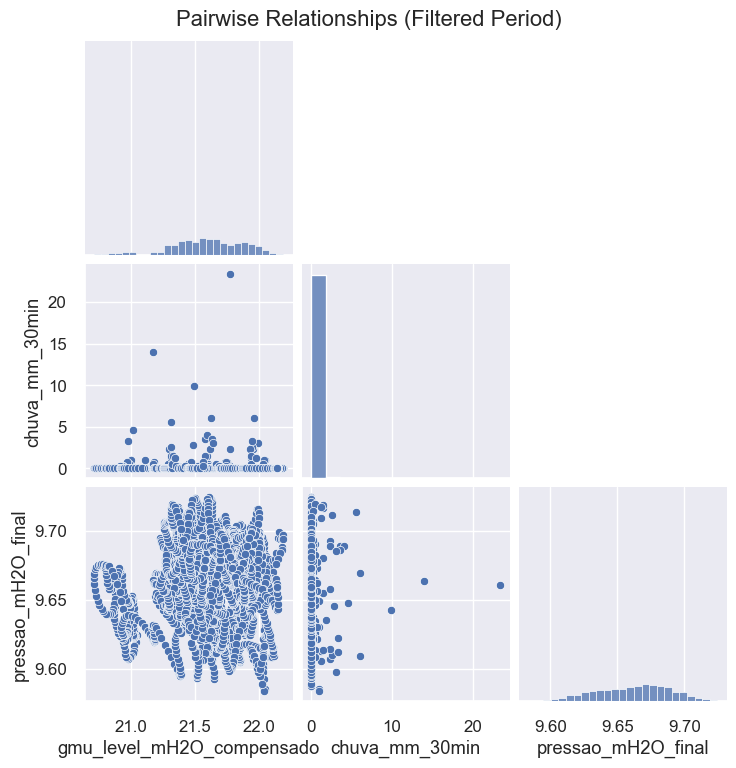

In [32]:
cols_for_pairplot = [
    col for col in ["gmu_level_mH2O_compensado", "chuva_mm_30min", "pressao_mH2O_final"]
    if col in data_ts.columns
]

if len(cols_for_pairplot) >= 2:
    sns.pairplot(
        data_ts[cols_for_pairplot].dropna(),
        corner=True,
    )
    plt.suptitle("Pairwise Relationships (Filtered Period)", y=1.02)
    plt.show()
else:
    print("Not enough numeric columns available for pairplot in the selected period.")


# # Cross-Correlation: Optimal Lag (Rain → Water Level)

C:\Users\peliz\AppData\Local\Temp\ipykernel_19516\3944252533.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  level = data_ts["gmu_level_mH2O_compensado"].fillna(method="ffill")


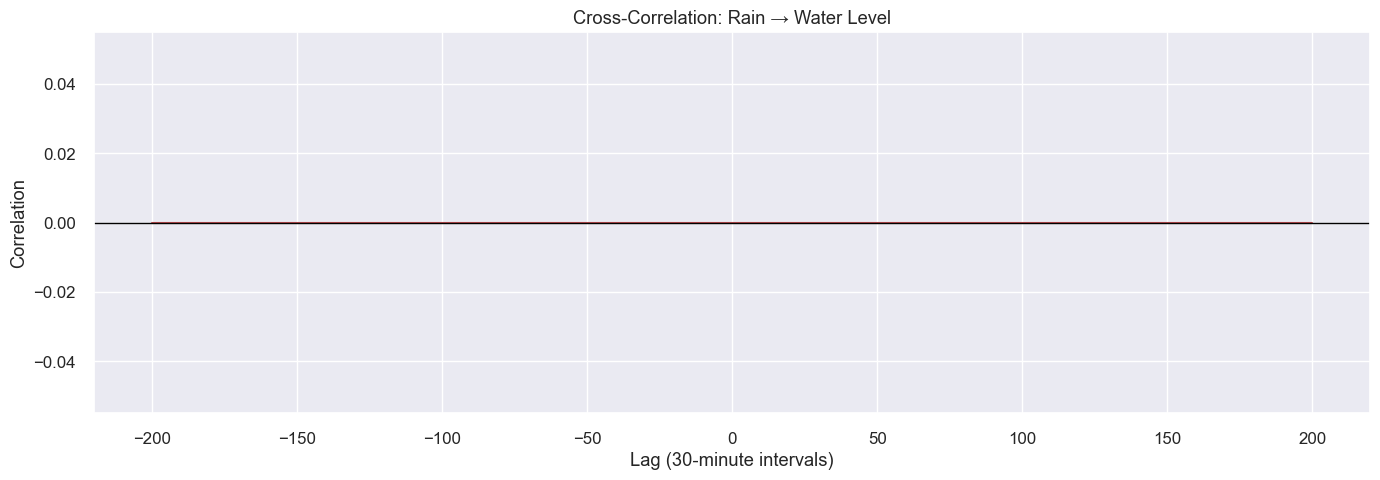

Best lag: -200 intervals
≈ -100.00 hours
≈ -4.17 days


In [33]:
# Select series (drop NaN to align signals)
rain = data_ts["chuva_mm_30min"].fillna(0)
level = data_ts["gmu_level_mH2O_compensado"].fillna(method="ffill")

max_lag = 200   # 200 lags = 100h = ~4 days
lags = np.arange(-max_lag, max_lag + 1)

ccf = [np.corrcoef(rain.shift(lag).fillna(0), level)[0, 1] for lag in lags]

plt.figure(figsize=(14,5))

# Compatible stem plot
markerline, stemlines, baseline = plt.stem(lags, ccf)
plt.setp(stemlines, linewidth=1)
plt.setp(markerline, markersize=4)

plt.axhline(0, color='black', linewidth=1)
plt.title("Cross-Correlation: Rain → Water Level")
plt.xlabel("Lag (30-minute intervals)")
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

best_lag = lags[np.argmax(ccf)]
print(f"Best lag: {best_lag} intervals")
print(f"≈ {best_lag * 0.5:.2f} hours")
print(f"≈ {best_lag / 48:.2f} days")